# Mapper limpio con análisis

## Librerías

In [4]:
import pandas as pd
import numpy as np
import random

import plotly
import requests
from bs4 import BeautifulSoup
import ruptures as rpt
import yfinance as yf

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import kmapper as km
import subprocess
import sys
import networkx as nx
subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly", "nbformat>=4.2.0"])
import sklearn.cluster

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



#### Funciones de docs en repositorio

from Funciones import calculate_metrics


## Recolección Datos

### Sacar tickers

In [5]:
START_DATE = "2025-01-01"
END_DATE = "2025-10-08"


# URL de la lista del S&P 500
url = "https://www.slickcharts.com/sp500"


# Hacer la petición con headers para evitar bloqueos
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Raise exception for bad status codes

# Parsear el HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrar la tabla
table = soup.find('table')

if table:
    # Leer la tabla con pandas
    df = pd.read_html(str(table))[0]
    
    # Extraer los tickers
    if 'Symbol' in df.columns:
        tickers = df['Symbol'].tolist()
        print(f"Found {len(tickers)} tickers")
        print("First 10 tickers:", tickers[:10])
    else:
        print("Available columns:", df.columns.tolist())

    # Extraer los pesos
    if 'Weight' in df.columns:
        weights = df['Weight'].tolist()
        print(f"Found {len(weights)} weights")
        print("First 10 weights:", weights[:10])
    else:
        print("Available columns:", df.columns.tolist())
else:
    print("No table found on the page")

# En la lista de ticker, reemplazar los "." por "-"
tickers = [ticker.replace('.', '-') for ticker in tickers]
print("Tickers after replacement:", tickers[:10])

Found 503 tickers
First 10 tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK.B']
Found 503 weights
First 10 weights: ['7.26%', '6.32%', '6.14%', '3.79%', '2.98%', '2.76%', '2.59%', '2.43%', '2.38%', '1.76%']
Tickers after replacement: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK-B']


### Descargar información financiera

In [6]:
# =======================================================
# 📊 RECOPILACIÓN DE INFORMACIÓN FUNDAMENTAL DE TICKERS
# =======================================================

print("🔍 Recopilando información detallada de todos los tickers del S&P 500...")
print("=" * 80)

ticker_info_db = {}
failed_tickers = []


for idx, ticker in enumerate(tickers, 1):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Extraer información relevante
        ticker_info_db[ticker] = {
            # Información básica
            'sector': info.get('sector', 'Unknown'),
            'industry': info.get('industry', 'Unknown'),
            'market_cap': info.get('marketCap', None),
            'country': info.get('country', 'Unknown'),
            'full_name': info.get('longName', ticker),
            
            # Métricas de valoración
            'pe_ratio': info.get('trailingPE', None),
            'forward_pe': info.get('forwardPE', None),
            'peg_ratio': info.get('pegRatio', None),
            'price_to_book': info.get('priceToBook', None),
            'price_to_sales': info.get('priceToSalesTrailing12Months', None),
            'enterprise_value': info.get('enterpriseValue', None),
            'ev_to_ebitda': info.get('enterpriseToEbitda', None),
            
            # Dividendos
            'dividend_yield': info.get('dividendYield', None),
            'dividend_rate': info.get('dividendRate', None),
            'payout_ratio': info.get('payoutRatio', None),
            'five_year_avg_dividend_yield': info.get('fiveYearAvgDividendYield', None),
            
            # Rentabilidad
            'profit_margins': info.get('profitMargins', None),
            'operating_margins': info.get('operatingMargins', None),
            'gross_margins': info.get('grossMargins', None),
            'roe': info.get('returnOnEquity', None),
            'roa': info.get('returnOnAssets', None),
            
            # Crecimiento
            'revenue_growth': info.get('revenueGrowth', None),
            'earnings_growth': info.get('earningsGrowth', None),
            'earnings_quarterly_growth': info.get('earningsQuarterlyGrowth', None),
            
            # Riesgo y volatilidad
            'beta': info.get('beta', None),
            '52week_high': info.get('fiftyTwoWeekHigh', None),
            '52week_low': info.get('fiftyTwoWeekLow', None),
            '52week_change': info.get('52WeekChange', None),
            
            # Liquidez y deuda
            'current_ratio': info.get('currentRatio', None),
            'quick_ratio': info.get('quickRatio', None),
            'debt_to_equity': info.get('debtToEquity', None),
            'total_debt': info.get('totalDebt', None),
            'total_cash': info.get('totalCash', None),
            
            # Analistas y recomendaciones
            'recommendation': info.get('recommendationKey', 'Unknown'),
            'recommendation_mean': info.get('recommendationMean', None),
            'target_mean_price': info.get('targetMeanPrice', None),
            'target_high_price': info.get('targetHighPrice', None),
            'target_low_price': info.get('targetLowPrice', None),
            'number_of_analysts': info.get('numberOfAnalystOpinions', None),
            
            # Información adicional
            'employees': info.get('fullTimeEmployees', None),
            'exchange': info.get('exchange', 'Unknown'),
            'quote_type': info.get('quoteType', 'Unknown'),
        }
        
        
    except Exception as e:
        failed_tickers.append(ticker)
        ticker_info_db[ticker] = {
            'sector': 'Unknown',
            'industry': 'Unknown',
            'error': str(e)
        }

print(f"\n{'='*80}")
print(f"📊 RESUMEN DE RECOPILACIÓN:")
if failed_tickers:
    print(f"   Tickers fallidos: {', '.join(failed_tickers[:10])}{'...' if len(failed_tickers) > 10 else ''}")

# Crear DataFrame para análisis fácil
ticker_info_df = pd.DataFrame.from_dict(ticker_info_db, orient='index')

print(f"\n DataFrame de información creado: {ticker_info_df.shape}")


# Guardar en CSV para uso posterior
ticker_info_df.to_csv('sp500_ticker_info_database.csv')
print("\n Base de datos guardada en 'sp500_ticker_info_database.csv'")

# Mostrar primeras filas
print("\n Primeras filas de la base de datos:")
display(ticker_info_df.head(10))

🔍 Recopilando información detallada de todos los tickers del S&P 500...

📊 RESUMEN DE RECOPILACIÓN:

 DataFrame de información creado: (503, 42)

 Base de datos guardada en 'sp500_ticker_info_database.csv'

 Primeras filas de la base de datos:

📊 RESUMEN DE RECOPILACIÓN:

 DataFrame de información creado: (503, 42)

 Base de datos guardada en 'sp500_ticker_info_database.csv'

 Primeras filas de la base de datos:


,sector,industry,market_cap,country,full_name,pe_ratio,forward_pe,peg_ratio,price_to_book,price_to_sales,...,total_cash,recommendation,recommendation_mean,target_mean_price,target_high_price,target_low_price,number_of_analysts,employees,exchange,quote_type
NVDA,Technology,Semiconductors,4385016381440,United States,NVIDIA Corporation,51.311966,43.714806,None,43.789204,26.540792,...,5.679100e+10,strong_buy,1.37500,218.51369,320.0,100.0,57.0,36000.0,NMS,EQUITY
MSFT,Technology,Software - Infrastructure,3818120019968,United States,Microsoft Corporation,37.603218,34.358530,None,11.117219,13.552697,...,9.456500e+10,strong_buy,1.25862,620.73690,710.0,483.0,51.0,228000.0,NMS,EQUITY
AAPL,Technology,Consumer Electronics,3705452363776,United States,Apple Inc.,37.888770,30.046568,None,56.350030,9.068100,...,5.537200e+10,buy,2.08333,248.12030,310.0,175.0,41.0,150000.0,NMS,EQUITY
AMZN,Consumer Cyclical,Internet Retail,2290215026688,United States,"Amazon.com, Inc.",32.735214,34.917560,None,6.858388,3.418037,...,9.318000e+10,strong_buy,1.29412,266.56450,306.0,230.0,62.0,1546000.0,NMS,EQUITY
META,Communication Services,Internet Content & Information,1802762977280,United States,"Meta Platforms, Inc.",26.029016,28.364428,None,9.255792,10.082341,...,4.707100e+10,strong_buy,1.41176,868.25696,1086.0,658.0,62.0,75945.0,NMS,EQUITY
AVGO,Technology,Semiconductors,1666121203712,United States,Broadcom Inc.,90.697945,57.182335,None,5.957600,27.802977,...,1.110500e+10,strong_buy,1.27660,385.89047,460.0,218.0,42.0,37000.0,NMS,EQUITY
GOOGL,Communication Services,Internet Content & Information,3031831412736,United States,Alphabet Inc.,26.689766,27.940850,None,8.349731,8.163273,...,9.514800e+10,buy,1.52239,249.05357,340.0,185.0,53.0,187103.0,NMS,EQUITY
GOOG,Communication Services,Internet Content & Information,3031290871808,United States,Alphabet Inc.,26.765457,28.051397,None,8.373411,8.161818,...,9.514800e+10,buy,1.51471,242.20557,285.0,185.0,18.0,187103.0,NMS,EQUITY
TSLA,Consumer Cyclical,Auto Manufacturers,1437213392896,United States,"Tesla, Inc.",258.817380,133.402790,None,18.023643,15.500576,...,3.678200e+10,hold,2.52174,366.38257,600.0,120.0,39.0,125665.0,NMS,EQUITY
BRK-B,Financial Services,Insurance - Diversified,1064614428672,United States,Berkshire Hathaway Inc.,16.926920,24.581125,None,0.001063,2.876162,...,3.440910e+11,buy,2.00000,519.66670,593.0,479.0,3.0,392400.0,NYQ,EQUITY


### Descargar Precios historicos

In [7]:
# -----------------------------
# Descargar precios históricos
# -----------------------------
tickers_data = yf.download(tickers, start=START_DATE, end=END_DATE, auto_adjust=True)['Close']
tickers_data = tickers_data.dropna(axis=1)  # eliminar columnas con datos faltantes

[*********************100%***********************]  503 of 503 completed



## Analisis inicial

In [8]:
# =======================================================
# 📈 ESTADÍSTICAS GENERALES DE LA BASE DE DATOS
# =======================================================

print("\n📈 ESTADÍSTICAS GENERALES DEL S&P 500:")
print("=" * 80)

# Distribución por Sector
print("\n🏢 DISTRIBUCIÓN POR SECTOR:")
sector_counts = ticker_info_df['sector'].value_counts()
for sector, count in sector_counts.items():
    pct = (count / len(ticker_info_df)) * 100
    print(f"   {sector:30s}: {count:3d} empresas ({pct:5.1f}%)")

# Top 10 Industrias
print("\n🏭 TOP 10 INDUSTRIAS:")
industry_counts = ticker_info_df['industry'].value_counts().head(10)
for industry, count in industry_counts.items():
    print(f"   {industry:50s}: {count:2d} empresas")

# Distribución por País
print("\n🌍 TOP 10 PAÍSES:")
country_counts = ticker_info_df['country'].value_counts().head(10)
for country, count in country_counts.items():
    pct = (count / len(ticker_info_df)) * 100
    print(f"   {country:30s}: {count:3d} empresas ({pct:5.1f}%)")

# Estadísticas de métricas financieras
print("\n💰 ESTADÍSTICAS DE MÉTRICAS FINANCIERAS (Medianas):")
financial_stats = {
    'Market Cap (Billones)': ticker_info_df['market_cap'].median() / 1e9 if ticker_info_df['market_cap'].notna().any() else None,
    'P/E Ratio': ticker_info_df['pe_ratio'].median(),
    'Beta': ticker_info_df['beta'].median(),
    'ROE (%)': ticker_info_df['roe'].median() * 100 if ticker_info_df['roe'].notna().any() else None,
    'Profit Margin (%)': ticker_info_df['profit_margins'].median() * 100 if ticker_info_df['profit_margins'].notna().any() else None,
    'Debt/Equity': ticker_info_df['debt_to_equity'].median(),
    'Dividend Yield (%)': ticker_info_df['dividend_yield'].median() * 100 if ticker_info_df['dividend_yield'].notna().any() else None,
}

for metric, value in financial_stats.items():
    if value is not None and not np.isnan(value):
        print(f"   {metric:25s}: {value:8.2f}")

# Empresas más grandes por Market Cap
print("\n🏆 TOP 10 EMPRESAS POR MARKET CAP:")
top_companies = ticker_info_df.nlargest(10, 'market_cap')[['full_name', 'sector', 'market_cap']]
for idx, (ticker, row) in enumerate(top_companies.iterrows(), 1):
    market_cap_b = row['market_cap'] / 1e9 if pd.notna(row['market_cap']) else 0
    print(f"   {idx:2d}. {ticker:5s} - {row['full_name'][:40]:40s} | ${market_cap_b:6.1f}B | {row['sector']}")

print(f"\n{'='*80}")
print("✅ Estadísticas generales completadas")


📈 ESTADÍSTICAS GENERALES DEL S&P 500:

🏢 DISTRIBUCIÓN POR SECTOR:
   Technology                    :  81 empresas ( 16.1%)
   Industrials                   :  72 empresas ( 14.3%)
   Financial Services            :  69 empresas ( 13.7%)
   Healthcare                    :  60 empresas ( 11.9%)
   Consumer Cyclical             :  55 empresas ( 10.9%)
   Consumer Defensive            :  37 empresas (  7.4%)
   Real Estate                   :  31 empresas (  6.2%)
   Utilities                     :  31 empresas (  6.2%)
   Communication Services        :  25 empresas (  5.0%)
   Energy                        :  22 empresas (  4.4%)
   Basic Materials               :  20 empresas (  4.0%)

🏭 TOP 10 INDUSTRIAS:
   Utilities - Regulated Electric                    : 23 empresas
   Software - Application                            : 17 empresas
   Specialty Industrial Machinery                    : 17 empresas
   Software - Infrastructure                         : 15 empresas
   Semiconductor

## Funciones

### Transfromaciones

### Visualizaciones

In [9]:

def plot_comparacion_clusters(G, ticker_names, metrics_df, title="Mapper sin nombre"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

    # Gráfico 1: Sharpe vs Volatilidad coloreado por nodos
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax1.scatter(node_data['volatility'], node_data['sharpe_ratio'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)
        
        # Agregar etiquetas de tickers cerca de los puntos
        for idx, ticker in enumerate(tickers_in_node):
            if len(tickers_in_node) <= 5:  # Solo si hay pocos tickers para evitar saturación
                ax1.annotate(ticker, (node_data['volatility'].iloc[idx], node_data['sharpe_ratio'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

    ax1.set_xlabel('Volatilidad')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title('Clusters Mapper: Sharpe vs Volatilidad\n(con nombres de tickers)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Retorno vs Drawdown coloreado por nodos
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        ax2.scatter(node_data['max_drawdown'], node_data['total_return'], 
                c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)

    ax2.set_xlabel('Max Drawdown')
    ax2.set_ylabel('Retorno Total')
    ax2.set_title('Clusters Mapper: Retorno vs Drawdown')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)



    # Gráfico 3: Volatilidad vs Retorno
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax3.scatter(node_data['volatility'], node_data['total_return'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=100)
        
        # Agregar etiquetas de tickers (solo si hay pocos)
        if len(tickers_in_node) <= 5:
            for idx, ticker in enumerate(tickers_in_node):
                ax3.annotate(ticker, 
                            (node_data['volatility'].iloc[idx], node_data['total_return'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8)

    ax3.set_xlabel('Volatilidad', fontsize=12)
    ax3.set_ylabel('Retorno Total', fontsize=12)
    ax3.set_title('⚖️ Volatilidad vs Retorno Total\n(Frontera eficiente: Alto retorno, baja volatilidad)', fontsize=13, fontweight='bold')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.axvline(x=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    # Gráfico 4: Volatilidad vs Drawdown
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax4.scatter(node_data['volatility'], node_data['max_drawdown'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=100)
        
        # Agregar etiquetas de tickers (solo si hay pocos)
        if len(tickers_in_node) <= 5:
            for idx, ticker in enumerate(tickers_in_node):
                ax4.annotate(ticker, 
                            (node_data['volatility'].iloc[idx], node_data['max_drawdown'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8)

    ax4.set_xlabel('Volatilidad', fontsize=12)
    ax4.set_ylabel('Max Drawdown (negativo)', fontsize=12)
    ax4.set_title('🎯 Volatilidad vs Max Drawdown\n(Menor volatilidad y menor drawdown = Mejor)', fontsize=13, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f'🔬 ANÁLISIS MULTIDIMENSIONAL: {title}', 
                fontsize=16, fontweight='bold', y=1.00)



    plt.tight_layout()
    plt.show()

## Creación

### Preparación

In [10]:
# =======================================================
# CREAR SUBCARPETA PARA VISUALIZACIONES
# =======================================================

import os

# Crear la subcarpeta para todas las visualizaciones
output_folder = 'visualizaciones_mapper_indice'
os.makedirs(output_folder, exist_ok=True)
print(f"📁 Subcarpeta creada: {output_folder}/")
print(f"🌐 Todas las visualizaciones HTML se guardarán en esta carpeta")

📁 Subcarpeta creada: visualizaciones_mapper_indice/
🌐 Todas las visualizaciones HTML se guardarán en esta carpeta


In [11]:
# Sacamos métricas de cada ticker

financial_metrics = {}
print("\n🔄 Calculando métricas financieras...")
for ticker in tickers_data.columns:
    try:
        prices = tickers_data[ticker].dropna()
        returns = prices.pct_change().dropna()
        
        # Métricas básicas
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        volatility = returns.std() * np.sqrt(252)  # Anualizada
        sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        
        # Métricas de riesgo
        max_drawdown = ((prices / prices.cummax()) - 1).min()
        var_95 = returns.quantile(0.05)  # Value at Risk 95%
        skewness = returns.skew()
        kurtosis = returns.kurtosis()
        
        # Métricas de tendencia
        returns_positive_ratio = (returns > 0).mean()
        trend_slope = np.polyfit(range(len(prices)), prices.values, 1)[0]
        
        financial_metrics[ticker] = {
            'total_return': total_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'var_95': var_95,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'positive_ratio': returns_positive_ratio,
            'trend_slope': trend_slope / prices.iloc[0]  # Normalizado
        }
    except Exception as e:
        print(f"❌ Error procesando {ticker}: {e}")

# Convertir a DataFrame
metrics_df = pd.DataFrame(financial_metrics).T

# Normalizar datos
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_df.fillna(0))

# Preparar datos para KeplerMapper (usar métricas financieras)
X = metrics_scaled  # Datos normalizados que ya tenemos
ticker_names = metrics_df.index.tolist()


print(f"📊 Datos preparados: {X.shape[0]} tickers, {X.shape[1]} métricas")

# 1. Crear el mapper
mapper = km.KeplerMapper(verbose=1)




🔄 Calculando métricas financieras...
📊 Datos preparados: 503 tickers, 9 métricas
KeplerMapper(verbose=1)
📊 Datos preparados: 503 tickers, 9 métricas
KeplerMapper(verbose=1)


### Configuraciones

In [12]:
# Configuración 1: Proyección por Sharpe
projected_data_sharpe = mapper.fit_transform(X, projection=[2])  # Sharpe ratio (índice 2)
covering = km.Cover(n_cubes=6, perc_overlap=0.5)
G = mapper.map(projected_data_sharpe, X, 
               clusterer=sklearn.cluster.KMeans(n_clusters=2),
               cover=covering)

mapper.visualize(G, 
                title='Mapper: Agrupación por Sharpe',
                color_values=metrics_df['sharpe_ratio'].values,
                color_function_name='Sharpe Ratio',
                node_color_function=np.array(['average','std','sum','max','min']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_principal_sharpe.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G['nodes'])}, Aristas: {len(G['links'])}")

..Composing projection pipeline of length 1:
	Projections: [2]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [2]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 6 hypercubes.

Created 16 edges and 12 nodes in 0:00:01.450167.
Wrote visualization to: visualizaciones_mapper_indice/mapper_principal_sharpe.html
Nodos: 12, Aristas: 10

Created 16 edges and 12 nodes in 0:00:01.450167.
Wrote visualization to: visualizaciones_mapper_indice/mapper_principal_sharpe.html
Nodos: 12, Aristas: 10


In [13]:
# Configuración 2: Proyección por Volatilidad

projected_data_vol = mapper.fit_transform(X, projection=[1])  # Volatilidad (índice 1)
covering_vol = km.Cover(n_cubes=8, perc_overlap=0.4)
G_vol = mapper.map(projected_data_vol, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=3),
                   cover=covering_vol)

mapper.visualize(G_vol, 
                title='Mapper: Agrupación por Volatilidad',
                color_values=metrics_df['volatility'].values,
                color_function_name='Volatilidad',
                node_color_function=np.array(['average','max']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_volatilidad.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_vol['nodes'])}, Aristas: {len(G_vol['links'])}")

..Composing projection pipeline of length 1:
	Projections: [1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 8 hypercubes.

Created 25 edges and 24 nodes in 0:00:00.030896.
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_volatilidad.html
Nodos: 24, Aristas: 17


In [14]:
# Configuración 3: Proyección por Retorno Total

projected_data_ret = mapper.fit_transform(X, projection=[0])  # Retorno total (índice 0)
covering_ret = km.Cover(n_cubes=7, perc_overlap=0.3)
G_ret = mapper.map(projected_data_ret, X, 
                   clusterer=sklearn.cluster.DBSCAN(eps=0.5, min_samples=1),
                   cover=covering_ret)

mapper.visualize(G_ret, 
                title='Mapper: Agrupación por Retorno Total',
                node_color_function=np.array(['average','std']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_retorno_total.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_ret['nodes'])}, Aristas: {len(G_ret['links'])}")

..Composing projection pipeline of length 1:
	Projections: [0]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [0]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 7 hypercubes.

Created 208 edges and 677 nodes in 0:00:00.072337.

Created 208 edges and 677 nodes in 0:00:00.072337.
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_retorno_total.html
Nodos: 677, Aristas: 208
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_retorno_total.html
Nodos: 677, Aristas: 208


In [15]:
# Configuración 4: Proyección Multi-dimensional (PCA)
projected_data_pca = mapper.fit_transform(X, projection='sum')  # Proyección suma
covering_pca = km.Cover(n_cubes=5, perc_overlap=0.6)
G_pca = mapper.map(projected_data_pca, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=2),
                   cover=covering_pca)

mapper.visualize(G_pca, 
                title='Mapper: Proyección PCA (Suma)',
                node_color_function=np.array(['min','average']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_pca_suma.html')  # Guardado en subcarpeta

..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 5 hypercubes.

Created 25 edges and 10 nodes in 0:00:00.020105.
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_pca_suma.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper: Proyección PCA (Suma) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13p

In [16]:
graphs={
    'Sharpe': G,
    'Volatilidad': G_vol,
    'Retorno': G_ret,
    'PCA': G_pca}


graph_names = list(graphs.keys())

categories = {ticker: ticker_info_db[ticker]['sector'] for ticker in ticker_names}
market_caps = {ticker: ticker_info_db[ticker]['market_cap'] for ticker in ticker_names}

## Indices

### Exraer información de mappers

In [17]:
"""
Analiza todos los clusters encontrados en los diferentes archivos Mapper
"""
print("  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER")
print("=" * 60)

# Diccionario para almacenar todos los clusters encontrados
all_clusters = {}
# 1. Extraer clusters del grafo G (Sharpe Ratio)
print(f"\n Extrayendo clusters del análisis por Sharpe Ratio (G):")
print(f"Total de nodos: {len(G['nodes'])}")

for i, (node_name, node_indices) in enumerate(G['nodes'].items()):
    if len(node_indices) >= 2:  # Solo clusters con al menos 2 tickers
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"Sharpe_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'Sharpe Ratio',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

# 2. Extraer clusters del grafo G_vol (Volatilidad)
print(f"\n Extrayendo clusters del análisis por Volatilidad (G_vol):")
print(f"Total de nodos: {len(G_vol['nodes'])}")

for i, (node_name, node_indices) in enumerate(G_vol['nodes'].items()):
    if len(node_indices) >= 2:
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"Vol_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'Volatilidad',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

# 3. Extraer clusters del grafo G_ret (Retorno)
print(f"\n Extrayendo clusters del análisis por Retorno (G_ret):")
print(f"Total de nodos: {len(G_ret['nodes'])}")

for i, (node_name, node_indices) in enumerate(G_ret['nodes'].items()):
    if len(node_indices) >= 2:
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"Return_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'Retorno Total',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

# 4. Extraer clusters del grafo G_pca (PCA)
print(f"\n🔬 Extrayendo clusters del análisis PCA (G_pca):")
print(f"Total de nodos: {len(G_pca['nodes'])}")

for i, (node_name, node_indices) in enumerate(G_pca['nodes'].items()):
    if len(node_indices) >= 2:
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"PCA_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'PCA',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

print(f"\n📋 RESUMEN: {len(all_clusters)} clusters encontrados en total")

  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER

 Extrayendo clusters del análisis por Sharpe Ratio (G):
Total de nodos: 12
     Sharpe_Cluster_1: ['DECK', 'DOW', 'FI', 'IT', 'KMX', 'LULU'] (6 tickers)
     Sharpe_Cluster_2: ['ACN', 'CAG', 'CLX', 'CMG', 'CPB', 'CPRT', 'CRM', 'EPAM', 'FDS', 'GDDY', 'HRL', 'IFF', 'OKE', 'STZ', 'TGT'] (15 tickers)
     Sharpe_Cluster_3: ['ACN', 'ADBE', 'AMCR', 'APO', 'ARE', 'AVB', 'AVY', 'BALL', 'BF-B', 'BMY', 'BRO', 'CAG', 'CARR', 'CDW', 'CHD', 'CL', 'CLX', 'CMCSA', 'CMG', 'COO', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRM', 'CTSH', 'DHR', 'DOV', 'DVA', 'DXCM', 'EIX', 'EOG', 'EPAM', 'EQIX', 'EQR', 'ERIE', 'FDX', 'FIS', 'FRT', 'FTV', 'GDDY', 'GIS', 'GPN', 'GWW', 'HON', 'HPQ', 'HRL', 'HSIC', 'IEX', 'IFF', 'INVH', 'IP', 'IR', 'ISRG', 'JBHT', 'JKHY', 'KDP', 'KHC', 'KKR', 'KMB', 'KVUE', 'LII', 'LYB', 'MAA', 'MKC', 'MRK', 'NOW', 'ODFL', 'OKE', 'PAYX', 'PCG', 'PG', 'POOL', 'PPG', 'PRU', 'PYPL', 'REGN', 'RVTY', 'SBUX', 'SW', 'TAP', 'TECH', 'TGT', 'TPL', 'TSN', 'TYL', 'UDR', '

### Nevos indices

### Pesos

In [19]:
# Convert market_caps dict to pandas Series
market_caps_series = pd.Series(market_caps)

# Mostrar muestra del DataFrame
print(f"\n📋 Muestra de las capitalizaciones:")
print(market_caps_series.head(10))
print(f"\n📊 Estadísticas de las capitalizaciones:")
print(f"   💰 Capitalización promedio: ${market_caps_series.mean():,.0f}")
print(f"   📈 Capitalización máxima: ${market_caps_series.max():,.0f}")
print(f"   📉 Capitalización mínima: ${market_caps_series.min():,.0f}")


📋 Muestra de las capitalizaciones:
A         39287488512
AAPL    3705452363776
ABBV     401317855232
ABNB      75917221888
ABT      224379977728
ACGL      33341634560
ACN      148572880896
ADBE     138184032256
ADI      117014052864
ADM       30591172608
dtype: int64

📊 Estadísticas de las capitalizaciones:
   💰 Capitalización promedio: $126,507,587,524
   📈 Capitalización máxima: $4,385,016,381,440
   📉 Capitalización mínima: $6,468,524,032


### Funciones creación indices

In [23]:
def create_market_cap_weighted_index(cluster_tickers, data, market_caps_dict, start_value=1):
    """
    Crea un índice ponderado por capitalización de mercado para un cluster específico.
    
    Parámetros:
    -----------
    cluster_tickers : list
        Lista de tickers del cluster
    data : pd.DataFrame
        DataFrame con precios históricos (tickers como columnas)
    market_caps_dict : dict
        Diccionario con {ticker: market_cap}
    start_value : float
        Valor inicial del índice (default: 1)
    
    Retorna:
    --------
    index_series : pd.Series
        Serie temporal del índice
    weights : dict
        Diccionario con los pesos de cada ticker
    """
    # Filtrar tickers que existen tanto en data como en market_caps
    valid_tickers = [t for t in cluster_tickers if t in data.columns and t in market_caps_dict]
    
    if not valid_tickers:
        print(f"⚠️  No hay tickers válidos en el cluster")
        return None, None
    
    # Calcular capitalización total del cluster
    total_market_cap = sum([market_caps_dict[ticker] for ticker in valid_tickers])
    
    # Calcular pesos de cada ticker (capitalización / capitalización total)
    weights = {ticker: market_caps_dict[ticker] / total_market_cap for ticker in valid_tickers}
    
    # Crear el índice
    index_series = pd.Series(0, index=data.index)
    
    for ticker, weight in weights.items():
        # Normalizar precios del ticker al valor inicial
        ticker_prices = data[ticker].dropna()
        if len(ticker_prices) > 0:
            ticker_normalized = (ticker_prices / ticker_prices.iloc[0]) * start_value
            # Agregar al índice con su peso
            index_series = index_series.add(ticker_normalized * weight, fill_value=0)
    
    return index_series, weights


def create_all_cluster_indices(all_clusters, data, market_caps_dict, start_value=1):
    """
    Crea índices ponderados por capitalización para todos los clusters.
    
    Parámetros:
    -----------
    all_clusters : dict
        Diccionario con todos los clusters {cluster_name: {tickers: [...], ...}}
    data : pd.DataFrame
        DataFrame con precios históricos
    market_caps_dict : dict
        Diccionario con {ticker: market_cap}
    start_value : float
        Valor inicial del índice (default: 1)
    
    Retorna:
    --------
    cluster_indices : dict
        Diccionario con {cluster_name: {index: serie, weights: dict, metrics: dict}}
    """
    cluster_indices = {}
    
    
    
    for cluster_name, cluster_info in all_clusters.items():
        cluster_tickers = cluster_info['tickers']
        cluster_type = cluster_info['type']
        
        
        
        # Crear índice para este cluster
        index_series, weights = create_market_cap_weighted_index(
            cluster_tickers, data, market_caps_dict, start_value
        )
        
        if index_series is not None:
            # Calcular métricas del índice
            returns = index_series.pct_change().dropna()
            
            total_return = (index_series.iloc[-1] / index_series.iloc[0] - 1) * 1
            volatility = returns.std() * np.sqrt(252) * 1
            sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
            max_drawdown = ((index_series / index_series.cummax()) - 1).min() * 1
            
            metrics = {
                'retorno_total': total_return,
                'volatilidad': volatility,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_drawdown,
                'valor_final': index_series.iloc[-1],
                'num_tickers': len(weights)
            }
            
            cluster_indices[cluster_name] = {
                'index': index_series,
                'weights': weights,
                'metrics': metrics,
                'type': cluster_type
            }
            
            
            
            # Mostrar los 3 tickers con mayor peso
            sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
            
        else:
            print(f"   ❌ No se pudo crear índice")
    
    
    
    return cluster_indices


def plot_cluster_indices(cluster_indices, benchmark_ticker='SPY', data=None, top_n=10):
    """
    Visualiza los índices de los clusters comparados con un benchmark.
    
    Parámetros:
    -----------
    cluster_indices : dict
        Diccionario con los índices de los clusters
    benchmark_ticker : str
        Ticker del benchmark (default: 'SPY')
    data : pd.DataFrame
        DataFrame con precios históricos (para obtener benchmark)
    top_n : int
        Número de mejores índices a resaltar (default: 10)
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('📊 Análisis de Índices Ponderados por Capitalización de Mercado', 
                 fontsize=16, fontweight='bold')
    
    # Subplot 1: Performance de todos los índices
    ax1 = axes[0, 0]
    for cluster_name, cluster_data in cluster_indices.items():
        ax1.plot(cluster_data['index'], alpha=0.3, linewidth=1)
    
    # Agregar benchmark si está disponible
    if data is not None and benchmark_ticker in data.columns:
        benchmark = (data[benchmark_ticker] / data[benchmark_ticker].iloc[0]) * 1
        ax1.plot(benchmark, color='red', linewidth=2, label=f'{benchmark_ticker} (Benchmark)', linestyle='--')
    
    ax1.set_title('Performance de Todos los Índices', fontweight='bold')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Valor del Índice (Base 1)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Subplot 2: Top N índices por Sharpe Ratio
    ax2 = axes[0, 1]
    sorted_by_sharpe = sorted(cluster_indices.items(), 
                              key=lambda x: x[1]['metrics']['sharpe_ratio'], 
                              reverse=True)[:top_n]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_by_sharpe)))
    for i, (cluster_name, cluster_data) in enumerate(sorted_by_sharpe):
        ax2.plot(cluster_data['index'], label=f"{cluster_name}", 
                color=colors[i], linewidth=2, alpha=0.8)
    
    if data is not None and benchmark_ticker in data.columns:
        benchmark = (data[benchmark_ticker] / data[benchmark_ticker].iloc[0]) * 1
        ax2.plot(benchmark, color='red', linewidth=2, label=f'{benchmark_ticker}', linestyle='--')
    
    ax2.set_title(f'Top {top_n} Índices por Sharpe Ratio', fontweight='bold')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Valor del Índice (Base 100)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=8, loc='best')
    
    # Subplot 3: Retorno vs Volatilidad (Scatter)
    ax3 = axes[1, 0]
    returns = [data['metrics']['retorno_total'] for data in cluster_indices.values()]
    vols = [data['metrics']['volatilidad'] for data in cluster_indices.values()]
    sharpes = [data['metrics']['sharpe_ratio'] for data in cluster_indices.values()]
    
    scatter = ax3.scatter(vols, returns, c=sharpes, s=100, alpha=0.6, 
                         cmap='RdYlGn', edgecolors='black', linewidth=1)
    
    # Añadir benchmark si está disponible
    if data is not None and benchmark_ticker in data.columns:
        bench_returns = (data[benchmark_ticker].pct_change().dropna())
        bench_ret = (data[benchmark_ticker].iloc[-1] / data[benchmark_ticker].iloc[0] - 1) * 1
        bench_vol = bench_returns.std() * np.sqrt(252) * 1
        ax3.scatter(bench_vol, bench_ret, color='red', s=200, marker='*', 
                   edgecolors='black', linewidth=2, label=benchmark_ticker, zorder=5)
    
    ax3.set_title('Retorno vs Volatilidad (Frontera Eficiente)', fontweight='bold')
    ax3.set_xlabel('Volatilidad (%)')
    ax3.set_ylabel('Retorno Total (%)')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Sharpe Ratio')
    ax3.legend()
    
    # Subplot 4: Métricas comparativas (barras)
    ax4 = axes[1, 1]
    cluster_names = list(cluster_indices.keys())[:15]  # Top 15 para legibilidad
    sharpe_values = [cluster_indices[name]['metrics']['sharpe_ratio'] for name in cluster_names]
    
    bars = ax4.barh(range(len(cluster_names)), sharpe_values, 
                    color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(cluster_names))))
    ax4.set_yticks(range(len(cluster_names)))
    ax4.set_yticklabels(cluster_names, fontsize=8)
    ax4.set_xlabel('Sharpe Ratio')
    ax4.set_title(f'Comparación de Sharpe Ratios (Top 15)', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax4.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return fig


def export_cluster_indices_to_csv(cluster_indices, filename='cluster_indices.csv'):
    """
    Exporta los índices de todos los clusters a un archivo CSV.
    
    Parámetros:
    -----------
    cluster_indices : dict
        Diccionario con los índices de los clusters
    filename : str
        Nombre del archivo CSV (default: 'cluster_indices.csv')
    """
    # Crear DataFrame con todos los índices
    indices_df = pd.DataFrame()
    
    for cluster_name, cluster_data in cluster_indices.items():
        indices_df[cluster_name] = cluster_data['index']
    
    # Guardar a CSV
    indices_df.to_csv(filename)
    print(f"✅ Índices exportados a: {filename}")
    print(f"   Dimensiones: {indices_df.shape}")
    
    # También crear un archivo con las métricas
    metrics_filename = filename.replace('.csv', '_metrics.csv')
    metrics_data = []
    
    for cluster_name, cluster_data in cluster_indices.items():
        metrics = cluster_data['metrics'].copy()
        metrics['cluster_name'] = cluster_name
        metrics['type'] = cluster_data['type']
        metrics_data.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df[['cluster_name', 'type', 'retorno_total', 'volatilidad', 
                             'sharpe_ratio', 'max_drawdown', 'valor_final', 'num_tickers']]
    metrics_df.to_csv(metrics_filename, index=False)
    print(f"✅ Métricas exportadas a: {metrics_filename}")
    
    return indices_df, metrics_df


print("✅ Funciones de índices ponderados cargadas:")
print("   - create_market_cap_weighted_index()")
print("   - create_all_cluster_indices()")
print("   - plot_cluster_indices()")
print("   - export_cluster_indices_to_csv()")

✅ Funciones de índices ponderados cargadas:
   - create_market_cap_weighted_index()
   - create_all_cluster_indices()
   - plot_cluster_indices()
   - export_cluster_indices_to_csv()


🔍 Verificando datos necesarios...
   ✓ all_clusters: 76 clusters
   ✓ tickers_data: (191, 503)
   ✓ market_caps: 503 tickers con capitalización

  CREACIÓN DE ÍNDICES PONDERADOS POR CAPITALIZACIÓN DE MERCADO

📊 Procesando: Sharpe_Cluster_1 (Sharpe Ratio)
   Tickers: 6
   ✅ Índice creado exitosamente
      💰 Retorno Total: -0.44%
      📊 Volatilidad: 0.31%
      📈 Sharpe Ratio: -2.29
      📉 Max Drawdown: -0.48%
      🏆 Top 3 pesos:
         FI: 0.47%
         LULU: 0.14%
         IT: 0.13%

📊 Procesando: Sharpe_Cluster_2 (Sharpe Ratio)
   Tickers: 15
   ✅ Índice creado exitosamente
      💰 Retorno Total: -0.28%
      📊 Volatilidad: 0.22%
      📈 Sharpe Ratio: -1.89
      📉 Max Drawdown: -0.32%
      🏆 Top 3 pesos:
         CRM: 0.33%
         ACN: 0.22%
         CMG: 0.08%

📊 Procesando: Sharpe_Cluster_3 (Sharpe Ratio)
   Tickers: 94
   ✅ Índice creado exitosamente
      💰 Retorno Total: -0.15%
      📊 Volatilidad: 0.19%
      📈 Sharpe Ratio: -1.06
      📉 Max Drawdown: -0.20%
      🏆 

🔍 Verificando datos necesarios...
   ✓ all_clusters: 76 clusters
   ✓ tickers_data: (191, 503)
   ✓ market_caps: 503 tickers con capitalización

  CREACIÓN DE ÍNDICES PONDERADOS POR CAPITALIZACIÓN DE MERCADO

📊 Procesando: Sharpe_Cluster_1 (Sharpe Ratio)
   Tickers: 6
   ✅ Índice creado exitosamente
      💰 Retorno Total: -0.44%
      📊 Volatilidad: 0.31%
      📈 Sharpe Ratio: -2.29
      📉 Max Drawdown: -0.48%
      🏆 Top 3 pesos:
         FI: 0.47%
         LULU: 0.14%
         IT: 0.13%

📊 Procesando: Sharpe_Cluster_2 (Sharpe Ratio)
   Tickers: 15
   ✅ Índice creado exitosamente
      💰 Retorno Total: -0.28%
      📊 Volatilidad: 0.22%
      📈 Sharpe Ratio: -1.89
      📉 Max Drawdown: -0.32%
      🏆 Top 3 pesos:
         CRM: 0.33%
         ACN: 0.22%
         CMG: 0.08%

📊 Procesando: Sharpe_Cluster_3 (Sharpe Ratio)
   Tickers: 94
   ✅ Índice creado exitosamente
      💰 Retorno Total: -0.15%
      📊 Volatilidad: 0.19%
      📈 Sharpe Ratio: -1.06
      📉 Max Drawdown: -0.20%
      🏆 

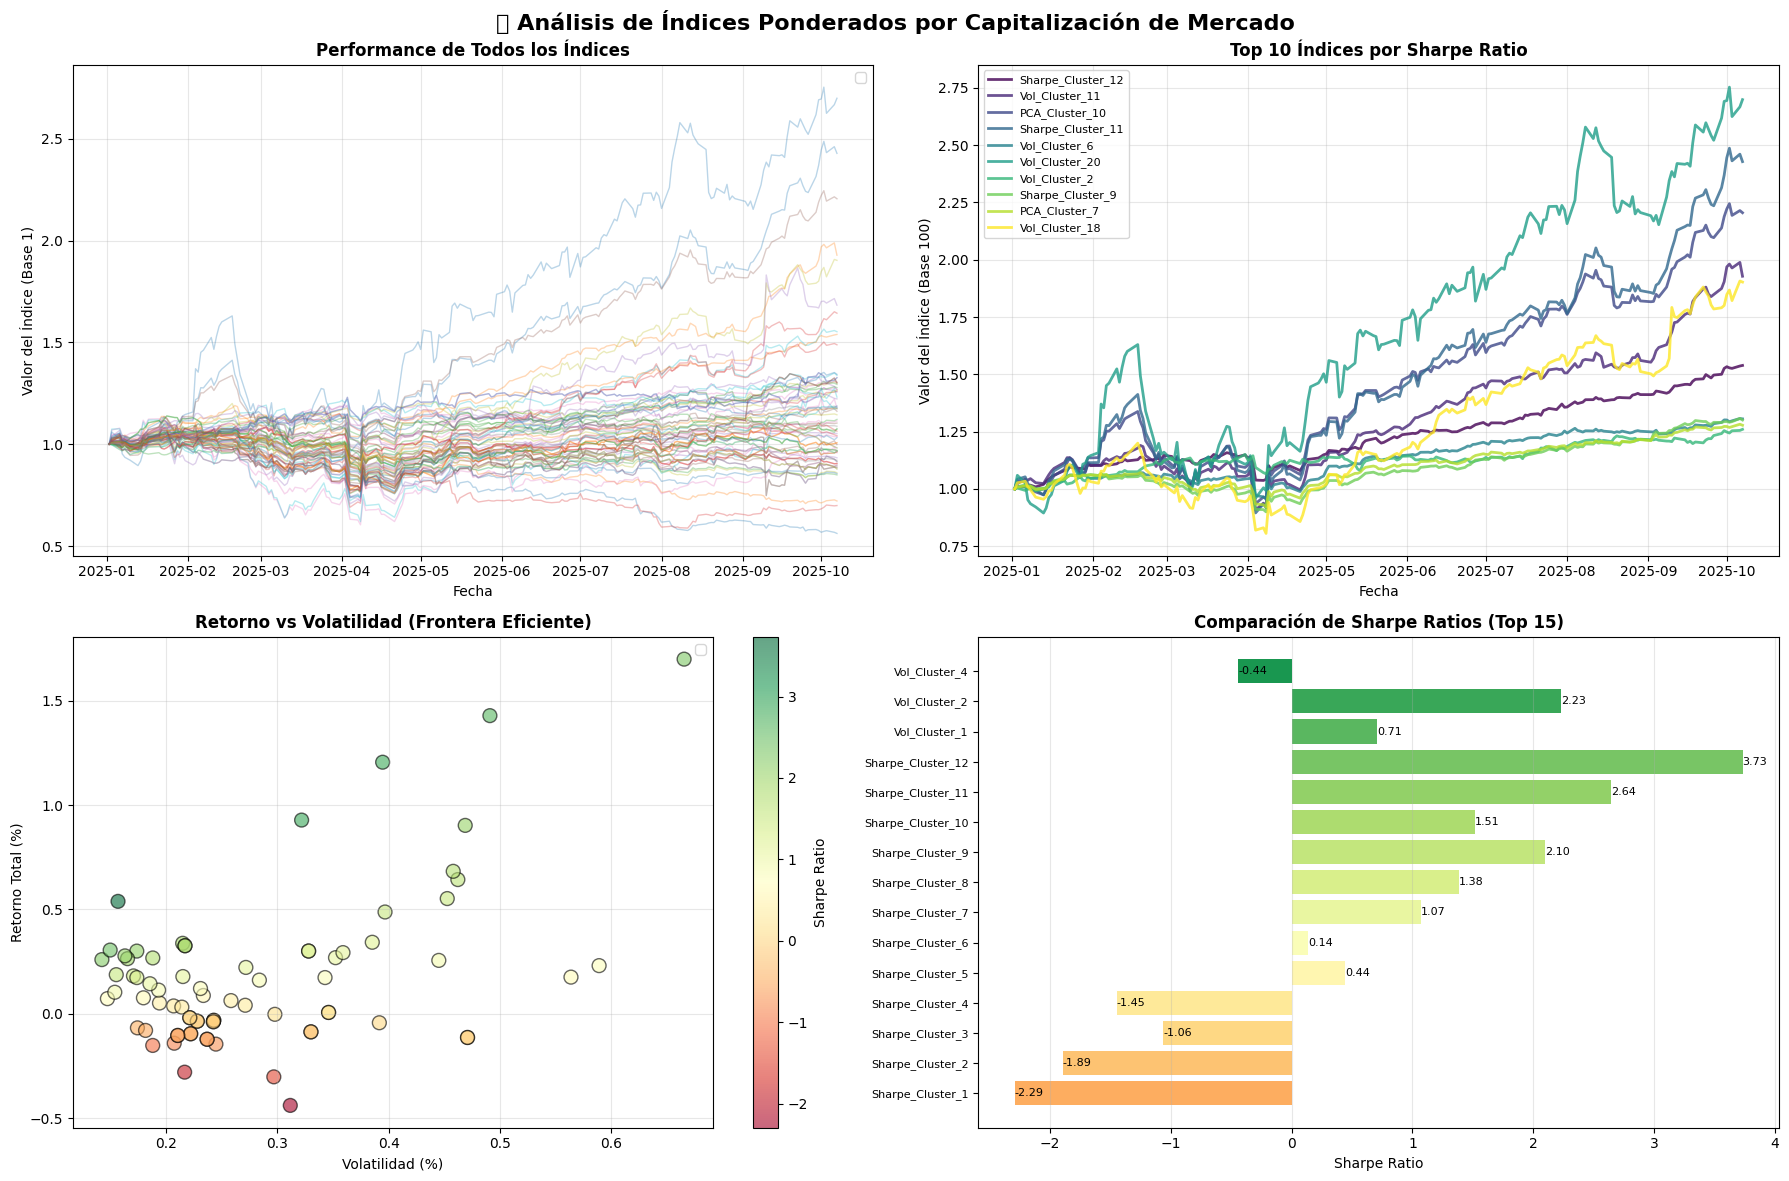



💾 Exportando resultados...
✅ Índices exportados a: cluster_indices_market_cap_weighted.csv
   Dimensiones: (191, 76)
✅ Métricas exportadas a: cluster_indices_market_cap_weighted_metrics.csv

  ANÁLISIS DETALLADO DEL MEJOR CLUSTER

🏆 Mejor Cluster: Sharpe_Cluster_12
   Tipo de análisis: Sharpe Ratio
   Número de tickers: 22

📊 Métricas:
   💰 Retorno Total: 0.54%
   📈 Volatilidad: 0.16%
   ⭐ Sharpe Ratio: 3.73
   📉 Max Drawdown: -0.10%
   💵 Valor Final: 1.54

🏆 Composición del índice (Pesos por Capitalización):
    1. JNJ   :   0.19% (Cap: $  460.94B)
    2. GE    :   0.13% (Cap: $  318.78B)
    3. RTX   :   0.09% (Cap: $  210.26B)
    4. APH   :   0.06% (Cap: $  154.12B)
    5. KLAC  :   0.06% (Cap: $  142.15B)
    6. WELL  :   0.05% (Cap: $  115.61B)
    7. MO    :   0.05% (Cap: $  109.20B)
    8. CVS   :   0.04% (Cap: $  102.79B)
    9. HCA   :   0.04% (Cap: $   98.29B)
   10. GD    :   0.04% (Cap: $   89.62B)
   11. HWM   :   0.03% (Cap: $   77.50B)
   12. BK    :   0.03% (Cap: $  

In [24]:
# Paso 1: Verificar que tenemos todos los datos necesarios
print("🔍 Verificando datos necesarios...")
print(f"   ✓ all_clusters: {len(all_clusters)} clusters")
print(f"   ✓ tickers_data: {tickers_data.shape}")
print(f"   ✓ market_caps: {len(market_caps)} tickers con capitalización")

# Paso 2: Crear índices para todos los clusters
cluster_indices = create_all_cluster_indices(
    all_clusters=all_clusters,
    data=tickers_data,
    market_caps_dict=market_caps,
    start_value=1
)

# Paso 3: Crear tabla resumen con métricas
print("\n" + "=" * 100)
print("  RESUMEN DE ÍNDICES CREADOS")
print("=" * 100)

summary_data = []
for cluster_name, cluster_data in cluster_indices.items():
    summary_data.append({
        'Cluster': cluster_name,
        'Tipo': cluster_data['type'],
        'Tickers': cluster_data['metrics']['num_tickers'],
        'Retorno (%)': cluster_data['metrics']['retorno_total'],
        'Volatilidad (%)': cluster_data['metrics']['volatilidad'],
        'Sharpe Ratio': cluster_data['metrics']['sharpe_ratio'],
        'Max Drawdown (%)': cluster_data['metrics']['max_drawdown'],
        'Valor Final': cluster_data['metrics']['valor_final']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)

print("\n📊 TOP 10 ÍNDICES POR SHARPE RATIO:")
print(summary_df.head(10).to_string(index=False))

print("\n\n📊 ESTADÍSTICAS GENERALES:")
print(f"   📈 Retorno promedio: {summary_df['Retorno (%)'].mean():.2f}%")
print(f"   📊 Volatilidad promedio: {summary_df['Volatilidad (%)'].mean():.2f}%")
print(f"   ⭐ Sharpe Ratio promedio: {summary_df['Sharpe Ratio'].mean():.2f}")
print(f"   📉 Max Drawdown promedio: {summary_df['Max Drawdown (%)'].mean():.2f}%")


In [ ]:

# Paso 4: Visualizar los índices
print("\n\n📊 Generando visualizaciones...")
plot_cluster_indices(
    cluster_indices=cluster_indices,
    benchmark_ticker='SPY',
    data=tickers_data,
    top_n=10
)

# Paso 5: Exportar a CSV
print("\n\n💾 Exportando resultados...")
indices_df, metrics_df = export_cluster_indices_to_csv(
    cluster_indices=cluster_indices,filename='cluster_indices_market_cap_weighted.csv'
)


### Ejemplo: Crear índice para un cluster específico

### Ejemplo de uso: Crear índices para todos los clusters

## 📊 Creación de Índices Ponderados por Capitalización de Mercado

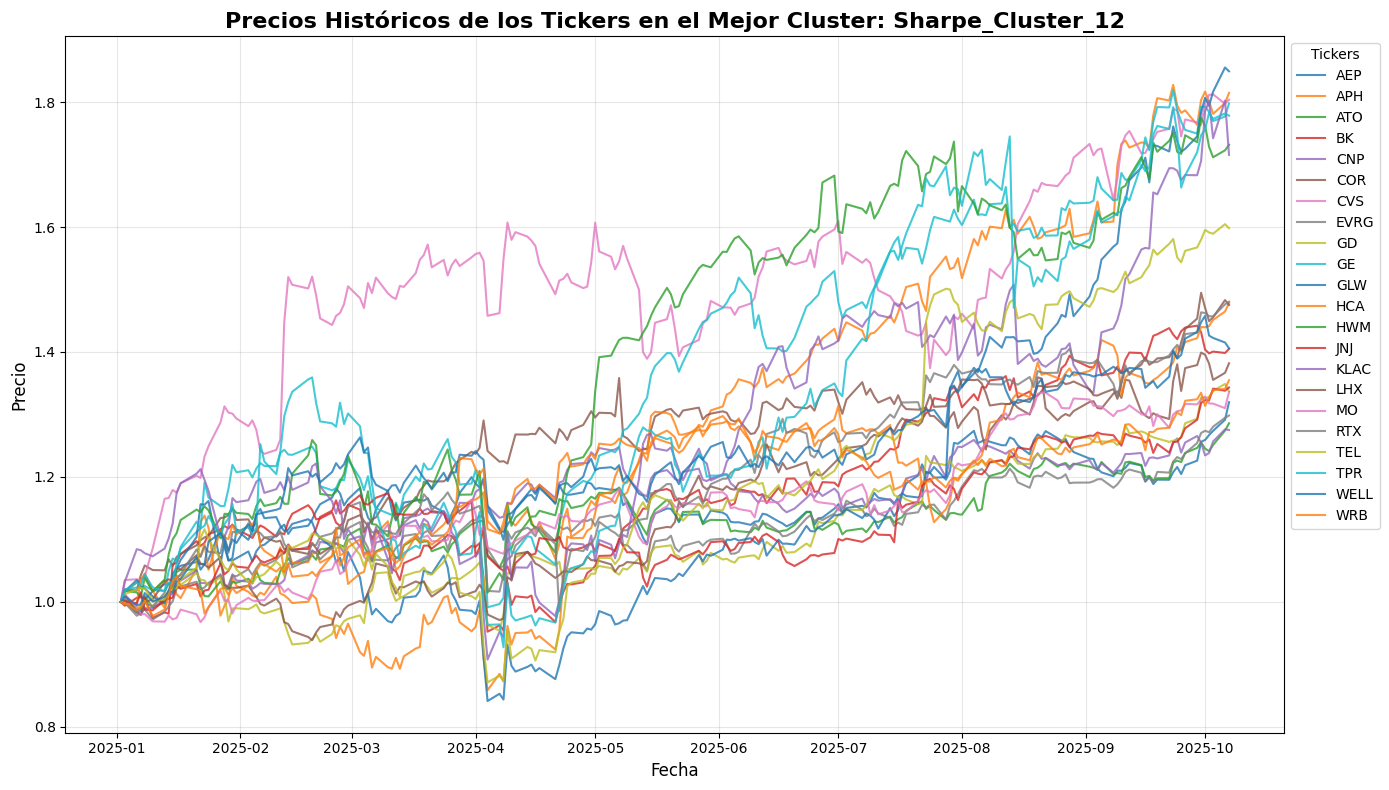

In [44]:
# Graficamos todos los tickers del mejor cluster en un solo gráfico
def plot_best_cluster_tickers(best_cluster_name, best_cluster, tickers_data):
    """
    Grafica los precios históricos de todos los tickers en el mejor cluster.

    Parámetros:
    -----------
    best_cluster_name : str
        Nombre del mejor cluster.
    best_cluster : dict
        Diccionario con información del mejor cluster, incluyendo los pesos y tickers.
    tickers_data : pd.DataFrame
        DataFrame con precios históricos de los tickers.
    """
    import matplotlib.pyplot as plt

    # Extraer los tickers del mejor cluster
    tickers = best_cluster['weights'].keys()

    # Crear la figura
    plt.figure(figsize=(14, 8))
    for ticker in tickers:
        if ticker in tickers_data.columns:
            plt.plot(tickers_data[ticker]/tickers_data[ticker].iloc[0], label=ticker, linewidth=1.5, alpha=0.8)
        else:
            print(f"⚠️ Ticker {ticker} no encontrado en tickers_data")

    # Configurar el gráfico
    plt.title(f"Precios Históricos de los Tickers en el Mejor Cluster: {best_cluster_name}", fontsize=16, fontweight='bold')
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Precio", fontsize=12)
    plt.legend(title="Tickers", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_best_cluster_tickers(best_cluster_name, best_cluster, tickers_data)

### Comapración y selección mejores

## Análisis mejores indices